# T-Maze Inference for Planning with GFE

This notebook reports the GFE for all policies for a variety of scenarios.

In [127]:
using LinearAlgebra
using ForneyLab
using Plots

include("factor_nodes/GFECategorical.jl")
include("update_rules/GFECategorical.jl")
;

# Model

In [128]:
fg = FactorGraph()

A = [0.5 0.0; 
     0.5 1.0]

B = [0.0 1.0;
     1.0 0.0]

C = [0.9, 0.1]

D = [0.8, 0.2]

@RV x_1 ~ Categorical(D)
GFECategorical(x_1, A, C)
@RV x_2 ~ Transition(x_1, B)
GFECategorical(x_2, A, C)
;

In [129]:
q = PosteriorFactorization(x_1, x_2, ids=[:X1, :X2])
algo = messagePassingAlgorithm(q, free_energy=true)
code = algorithmSourceCode(algo, free_energy=true)
eval(Meta.parse(code))
;

In [130]:
# println(code)

# Results

In [131]:
n_its = 5
G = zeros(n_its*2)
p_0 = [0.5, 0.5]
p = Vector{Vector{Float64}}(undef, n_its*2) # Coordinates

data = Dict()

marginals = Dict{Symbol, ProbabilityDistribution}(
    :x_1 => ProbabilityDistribution(Univariate, Categorical, p=[p_0[1], 1.0 - p_0[1]]),
    :x_2 => ProbabilityDistribution(Univariate, Categorical, p=[p_0[2], 1.0 - p_0[2]]))

for k=1:n_its
    stepX1!(data, marginals)
    p[2*k - 1] = [marginals[:x_1].params[:p][1], marginals[:x_2].params[:p][1]]
    G[2*k - 1] = freeEnergy(data, marginals)
    stepX2!(data, marginals)
    p[2*k] = [marginals[:x_1].params[:p][1], marginals[:x_2].params[:p][1]]
    G[2*k] = freeEnergy(data, marginals)
end

G = G./log(2) # Convert to bits
;


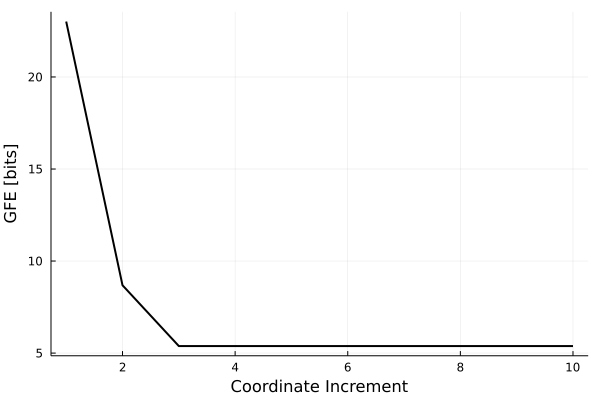

In [132]:
plot(1:n_its*2, G, color=:black, grid=true, linewidth=2, legend=false, xlabel="Coordinate Increment", ylabel="GFE [bits]")

# Landscape

In [133]:
xs_1 = 0.0:0.1:1.0
m = length(xs_1)
xs_2 = 0.0:0.1:1.0
n = length(xs_2)
Gs = zeros(m, n)
for i = 1:m
    for j = 1:n
        data = Dict()

        p_x_1 = [xs_1[i], 1.0 - xs_1[i]]
        m_x_1 = Distribution(Univariate, Categorical, p=p_x_1)
        p_x_2 = [xs_2[j], 1.0 - xs_2[j]]
        m_x_2 = Distribution(Univariate, Categorical, p=p_x_2)
        marginals = Dict{Symbol, ProbabilityDistribution}(:x_1 => m_x_1, :x_2 => m_x_2)
        Gs[i, j] = freeEnergy(data, marginals)
    end
end

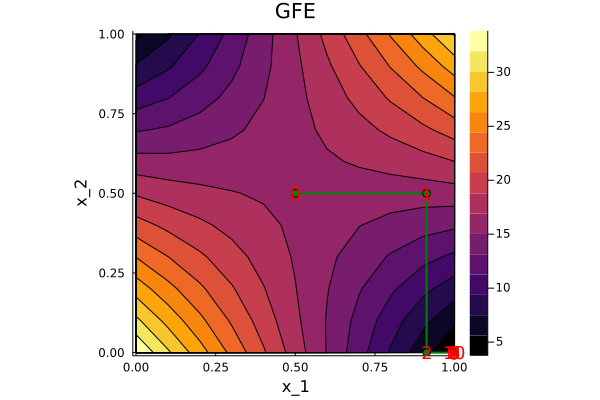

In [134]:
plt = plot(xs_1,
           xs_2,
           Gs',
           st=:contour,
           fill=true,
           dpi=100,
           aspect_ratio=:equal, 
           xlim=(-0.01,1.01), 
           ylim=(-0.01,1.01), 
           xlabel="x_1",
           ylabel="x_2",
           title="GFE")

p_1 = [p_0[1]]
p_2 = [p_0[2]]
for p_k in p
    push!(p_1, p_k[1])
    push!(p_2, p_k[2])
end
plot!(p_1, p_2, color=:green, marker=:o, linewidth=2, legend=false)

for k=1:n_its*2+1
    ann = (p_1[k], p_2[k], text(k-1, 12, :red, :center))
    annotate!(ann, linecolor=:red)
end

plt